# Set up

### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import librosa
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd 
import seaborn as sns

#import librosa.display
#import matplotlib   
#import IPython.display as ipd
#from scipy.io import wavfile

from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.signal import welch
from scipy.integrate import simps

#import scipy 

import operator #Used to sort 
import glob #
import json
from datetime import datetime

##import warnings
##warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [ ]:
df_paths = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/wav_paths_master.csv") 
df_paths['mic'] = df_paths['mic'].str.replace("l", "").str.replace("m", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 
#df_paths["filename"] = df_paths.path.str.replace('/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset', '')

#df_presaved = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/preloaded_files_csv/combined_csv.csv") 
#df_files = pd.merge(df_presaved, df_paths, on="filename", how="inner")
#df_files.drop(columns=["index", "filename"], inplace=True)


# Functions

## Helper functions 

In [ ]:
def join_meta(df_meta, df_input):
  df = df_input.join(df_meta)
  df.index.name = "index"
  return df

In [ ]:
from scipy.signal import butter, lfilter, filtfilt, sosfilt

def butter_highpass(cutoff, fs, order=9):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=9):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def pre_save_files(df_input, cutoff=0, save_path=None, sr=None):
  df_files = pd.DataFrame()
  
  for ind in tqdm(df_input.index):
    y, sample_rate = librosa.load(df_input['path'][ind], sr=None)
    if type(cutoff) == int and cutoff > 0: 
      y = butter_highpass_filter(y, cutoff, sample_rate,order=4)
    df_file = pd.DataFrame({"samples": [y], "sr": sample_rate})
    df_files = pd.concat([df_files, df_file], join = 'outer', axis = 0)
  df_files.index = df_input.index
  
  if save_path:
    df_files.to_json(save_path)


  return df_files



In [ ]:
def preprocesses(X,T,normalize=True):
  if normalize:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    T_scaled = pd.DataFrame(scaler.transform(T))
    T_scaled.columns = T.columns

  return X_scaled, T_scaled 


In [ ]:
def make_list(split_list): #[0,10000,1000]
  split = split_list.copy()
  split[1] = split[1]+split[-1]
  splitted_list =  np.arange(split[0], split[1], split[2]).tolist()
  return splitted_list

In [ ]:
def invert_preds(preds):
  return np.abs(preds-1)

def get_accuracy(pred, gt):
  score = 0 
  if len(pred) != len(gt):
    return
  for i in range(len(pred)):
    if pred[i] == gt[i]:
      score+=1

  accuracy = np.round(score/len(pred),4)

  if accuracy < 0.1:
    accuracy=1-accuracy

  return accuracy

In [ ]:
def get_wanted_files(df, wanted_files):
    for key in wanted_files:
        if wanted_files[key]:
            df = df.loc[(df[key].isin(wanted_files[key]))]
    return df 


In [ ]:
def add_white_noise(signal,noise_factor):
  noise = np.random.normal(0,signal.std(),signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

def random_gain(signal, min_gain_factor, max_gain_factor):
  gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
  return signal * gain_factor

In [ ]:
def bandpower(data, sf, band_list, window_sec=None, relative=False, reduce_split=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """


    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = 0.3 * sf

    # Compute the modified periodogram (Welch)
    #win = scipy.signal.get_window('hanning',nperseg)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    avg_band_power = []

    #Kan vurdere å bruke matplotlib sin psd 
    ##win = matplotlib.mlab.window_hanning(np.ones(nperseg)) # or
    ##psd, freqs = matplotlib.mlab.psd(data, Fs=sf,window=win)



    # Frequency resolution
    for i in range(len(band_list)-1):
      freq_res = freqs[1] - freqs[0]
      low = band_list[i]
      high = band_list[i+1]

      # Find closest indices of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)

      # Integral approximation of the spectrum using Simpson's rule.
      bp = simps(psd[idx_band], dx=freq_res)


      if relative:
          bp /= simps(psd, dx=freq_res)

      
      avg_band_power.append(bp)


    if reduce_split:
      reduced = []  
      for i in range(len(reduce_split)-1):
        s = avg_band_power[reduce_split[i]:reduce_split[i+1]]
        reduced.append(sum(s))
      return pd.DataFrame([reduced])

    return pd.DataFrame([avg_band_power])

In [ ]:
def plot_learning_curve(estimator, title, X, y,cv=None, n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 5),):
  plt.figure(figsize=(8,5))
  train_sizes, train_scores, test_scores = learning_curve(estimator,X,y)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",)
  plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")


  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",)
  plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

  plt.legend(loc="best")
  plt.title(title)
  plt.show()

In [ ]:
def plot_corr_matrix(df_features):
  # run correlation matrix and plot
  f, ax = plt.subplots(figsize=(10, 8))
  corr = df_features.corr()
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
              cmap=sns.diverging_palette(220, 10, as_cmap=True),
              square=True, ax=ax)

## Feature functions

In [ ]:
#Kan hende denne kan slettes? 
def get_bandpower_dataframe(df_input,window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()

  if split_list[0] == "even": 
    band_list = make_list(split_list)
  else: 
    band_list = split_list[0]
  
  for ind in tqdm(df_input.index):
    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]
    bin_power = bandpower(signal, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
    df = pd.concat([df,bin_power],axis=0,ignore_index=True)
  
  df.index = df_input.index
  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names

  return df

"""
Split_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list
A unneccesery way of doing it but I like that I still can get the firste version without reduced split
"""
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000])
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1])
#df_rel_pwr_train


'\nSplit_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list\nA unneccesery way of doing it but I like that I still can get the firste version without reduced split\n'

In [ ]:
def get_data_labels(df_train_features, df_test_features, drop_features=None):

  df_train_features_drop = df_train_features.drop(columns=['Unnamed: 0','feature_index', 'index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')
  df_test_features_drop = df_test_features.drop(columns=['Unnamed: 0','feature_index','index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')


  y = df_train_features_drop['leak_present'].values
  X = df_train_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    X = X.drop(columns=drop_features)

  gt = df_test_features_drop['leak_present'].values
  T = df_test_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    T = T.drop(columns=drop_features)



  return X,y,T,gt


## Feature Extraction

In [ ]:
def get_train_test_dataframes_presaved(df, train_files, test_files, verbose):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test


In [ ]:
def get_train_test_dataframes(df, train_files, test_files, cutoff=0, verbose=0):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    df_train_loaded = pre_save_files(df_train, cutoff=cutoff)
    df_test_loaded = pre_save_files(df_test, cutoff=cutoff)

    df_train = join_meta(df_train_loaded, df_train)
    df_test = join_meta(df_test_loaded, df_test)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test



In [ ]:
def get_train_test_features(df_train, df_test, use_features, split_list, relative_power, win_len, log_rel_pwr, shuffle):

  print("> making train features")
  df_train_features = get_all_features(df_train, use_features, split_list, relative_power, win_len,log_rel_pwr=False) 
  df_train_features = df_train_features.loc[:, ~df_train_features.columns.duplicated()]
  df_train_features = df_train_features.join(df_train, on="feature_index", how="left")
  print("")

  
  print("> making test features")
  df_test_features = get_all_features(df_test,use_features, split_list, relative_power, win_len,log_rel_pwr=False) 
  df_test_features = df_test_features.loc[:, ~df_test_features.columns.duplicated()]
  df_test_features = df_test_features.join(df_test, on="feature_index",how="left")
  print("")




  if log_rel_pwr:
    #x_norm, t_norm = preprocesses(df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin'))
    x_norm, t_norm = df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin')

    x_norm_log = np.log(x_norm) #Can test log10, log2 as well
    t_norm_log = np.log(t_norm)    
    df_train_features.loc[x_norm_log.index.isin(df_train_features.index), x_norm_log.columns.values] = x_norm_log[x_norm_log.columns.values]
    df_test_features.loc[t_norm_log.index.isin(df_test_features.index), t_norm_log.columns.values] = t_norm_log[t_norm_log.columns.values]

  if shuffle: 
    df_train_features = shuffle(df_train_features)
    df_test_features = shuffle(df_test_features)


  return df_train_features, df_test_features


In [ ]:
def get_all_features(df, use_features, split_list, relative_power, win_len=0.3, log_rel_pwr=False):

  if "time-freq" in use_features: 
    print("time-frequency features")
    df_freq = get_time_freq_feature_dataframe(df, win_len=win_len)
  else: 
    df_freq = pd.DataFrame()

  if "rel-pwr" in use_features: 
    print("relative power features")
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 2500])
    df_relative_pwr = get_bandpower_dataframe_framed(df,win_len=win_len, window_sec=1, split_list=split_list, relative_power=relative_power)
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1]) #This reduce split means: from 0-6kHz, 6-13kHz, and 13kHz to the end
    #if log_rel_pwr: 
    #  df_relative_pwr = np.log10(df_relative_pwr)
    print("done!")
  else: 
    df_relative_pwr = pd.DataFrame()



  #df_all_features = df_freq.join(df_relative_pwr, on="index")
  df_freq.reset_index(inplace=True)
  df_relative_pwr.reset_index(inplace=True)
  
  df_all_features = pd.concat([df_freq,df_relative_pwr],axis=1)

  df_all_features.columns = df_all_features.columns.astype(str)

  #df_all_features.index = df
  return df_all_features 
  

In [ ]:
def get_time_freq_feature_dataframe(df_input, win_len):
  FRAME_LENGTH = int((win_len * 48000)) #48000 is the expected sample rate
  HOP_LENGTH = FRAME_LENGTH // 2 #50% overlap

  features = []

  for ind in tqdm(df_input.index):
    #feature_list = freq_domain_features(np.array(df_input["samples"][ind]), df_input["sr"][ind], ind, win_len=win_len)

    feature_list_time = time_domain_features(df_input["samples"][ind],df_input["sr"][ind], win_len=win_len, return_empty=True)
    #feature_list_freq = freq_domain_features(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)
    #feature_list_freq = freq_domain_features_V2(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)
    feature_list_freq = freq_domain_features_V3(df_input["samples"][ind],df_input["sr"][ind], ind, FRAME_LENGTH=FRAME_LENGTH,HOP_LENGTH=HOP_LENGTH)

    feature_list = pd.concat([feature_list_time, feature_list_freq], join = 'outer', axis = 1)
    
    features.append(feature_list)

  df = pd.concat(features, ignore_index=True)


  return df


In [ ]:
def time_domain_features(signal, sr, win_len, return_empty=False):
  if return_empty:
    return pd.DataFrame()
    
  mean = []
  max = []
  std = []
  kurt = []
  skew = []
  #rms = []
  crest_factor = []
  PPV = []


  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2

  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%
  #print(frames.shape)
  for frame in frames: 
    mean.append(np.mean(frame))
    max.append(np.max(np.abs(frame)))
    std.append(np.std(frame))
    
    #rms.append(compute_rms(frame))
    #crest_factor.append(np.max(np.abs(frame)) / compute_rms(frame))



  features = [mean, std, max]
  names = ["mean", "std", "max"]


  dft = pd.DataFrame(features).T

  dft.columns = names
  return dft


In [ ]:
def freq_domain_features_V2(signal, sr, index, win_len=1, no_panda=False,):
  
  FRAME_LENGTH = sr * 5
  HOP_LENGTH = sr #FRAME_LENGTH
  rmse=librosa.feature.rms(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
  spec_cent = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  zcr = librosa.feature.zero_crossing_rate(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, )
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))  

  features = [np.mean(rmse), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
  for e in mfcc:
    features.append(np.mean(e))
  
  for c in spec_contrast:
    features.append(np.mean(c))

  df = pd.DataFrame(features).T
  df["feature_index"] = [index]
  #df.index.name = "feature_index"
  return df
  

In [ ]:
from scipy.stats import kurtosis, skew

def freq_domain_features_V3(signal, sr, index, FRAME_LENGTH,HOP_LENGTH, no_panda=False,):

  #FRAME_LENGTH = int(sr * win_len)
  #HOP_LENGTH = FRAME_LENGTH//2
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=6, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False) #Using 6 MFCC bins 
  df_mfcc = pd.DataFrame(mfcc).T
  names_mfcc = [str("mfcc_bin: " + str(i)) for i in range(len(np.array(df_mfcc.columns)))]
  df_mfcc.columns = names_mfcc
  
  #RETURNS 1D FEAUTRE LIST 
  zcr = librosa.feature.zero_crossing_rate(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0]
  rmse=librosa.feature.rms(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0]
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness, zcr, rmse] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness", "zcr", "rmse"]
  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_flat,df_contrast,df_mfcc],axis=1)
  index_col = (np.ones(len(frames))*index)
  #df["feature_index"] = index_col
  df.insert(0, "feature_index", index_col)

  return df

In [ ]:
from scipy.stats import kurtosis, skew

def freq_domain_features(signal, sr, index, win_len=1, no_panda=False,):
  peak_freq = []
  peak_freq_amp = []

  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2
  
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%


  #for frame in frames: 
  #  peak_freq.append((n_max_freq_amp(1,frame, sr)[0])[0])
  #  peak_freq_amp.append((n_max_freq_amp(1,frame, sr)[1])[0])

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  #RETURNS 1D FEAUTRE LIST 
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))
  #spec_rms = (librosa.feature.rms(S=S, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False)[0]).T

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness"]


  index_col = (np.ones(len(frames))*index)
  flat_features += [index_col]
  flat_names += ["feature_index"]

  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_contrast,df_flat],axis=1)

  return df

In [ ]:

def get_bandpower_dataframe_framed(df_input, win_len, window_sec, split_list, relative_power, reduce_split=False):
  df = pd.DataFrame()


  #band_list = make_list(split_list)
  #band_list = [0,1000,10000,15000,20000,24000]

  if split_list[0] == "manual": 
    band_list = split_list[1]
  else: 
    band_list = make_list(split_list[1])

  #for ind in tqdm(df_input.index):
  for ind in (df_input.index):

    df_signal = pd.DataFrame()

    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]

    #win_len = librosa.get_duration(y=signal, sr=sr)//2
    FRAME_LENGTH = int(sr * win_len)
    HOP_LENGTH = FRAME_LENGTH//2
    frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T 
    
    for frame in frames:
      bin_power = bandpower(frame, sr, band_list ,window_sec=window_sec, relative=relative_power, reduce_split=reduce_split)
      bin_power['index'] = [float(ind)]
      
      df_signal = pd.concat([df_signal,bin_power],axis=0)
    
    df = pd.concat([df,df_signal],axis=0,)

  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names
  df.columns = [*df.columns[:-1], 'feature_index']

  return df

#get_bandpower_dataframe_framed(df.head(5), win_len=10, window_sec=1, split_list=[0, 24000, 2500])

## ML functions

In [ ]:
def plot_model_learning_curves(trained_models, train_data, labels):
  for model in trained_models:
    plot_learning_curve(trained_models[model], model, train_data, labels )
  return 

def plot_feature_importance(trained_models,train_data):
      features = train_data.columns
      for model in trained_models:
        try: 
          tree_feature_importances = trained_models[model].feature_importances_
          indices = np.argsort(tree_feature_importances)
          plt.figure(figsize=(15,10)) 
          plt.title(model + ' Feature Importances')
          plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
          plt.yticks(range(len(indices)), [features[i] for i in indices])
          plt.xlabel('Relative Importance')
        except:
          plt.close()
        #plt.show()

def plot_decsion_tree(trained_models, train_data):
  fn = train_data.columns.values
  cn=['no_leak', 'leak']
  model = "dt"
  #Text tree representation
  print("Text representation of decision tree: ")
  print("")
  print(tree.export_text(trained_models[model],decimals=4))
  print("")

  #Plot three representation
  fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
  tree.plot_tree(trained_models[model],
                feature_names = fn, 
                class_names=cn,
                precision=4,
                filled = True)
  plt.title("Visual representation of decision tree")
  plt.show()

def plot_confusion_matricies(trained_models, test_data, test_label):
  for model in trained_models:
      try:
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title(model + " confusion matrix")
        disp = ConfusionMatrixDisplay.from_estimator(
            trained_models[model],
            test_data,
            test_label,
            display_labels=[0,1],
            cmap=plt.cm.Blues,
            normalize=None,
            ax=ax) 
      except:
        plt.close()

In [ ]:
def plot_model_information(trained_models,train_data,train_labels, test_data, test_labels, tree_plot, learning_curves, feature_importance, confusion_matrix):
  if tree_plot:
    plot_decsion_tree(trained_models, train_data)
  if learning_curves:
    plot_model_learning_curves(trained_models,train_data,train_labels)
  if feature_importance:
    plot_feature_importance(trained_models,train_data)
  if confusion_matrix:
    plot_confusion_matricies(trained_models, test_data,test_labels)



In [ ]:
def store_files_and_score(scores, train_files, test_files,features, save_path):
  now = datetime.now()
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S") #Setting the key to current time 

  one_run = {
      dt_string : {
        "scores":scores,
        "train_files":train_files,
        "test_files":test_files,
        "features":features,
        }
      }

  if save_path:
    try: 
      with open(save_path, "r+") as file: #If file excists we append the results
        data = json.load(file)
        data.update(one_run)
        file.seek(0)
        json.dump(data, file,indent=5)
    except: #Has to create the file if it does not excist 
      with open(save_path, "w") as file:
        json.dump(one_run, file,indent=5)

  else: 
    return 

In [ ]:
def read_run_plan(run_plan_path):
  with open(run_plan_path, 'r') as f:
    return json.load(f)


In [ ]:
def run_several_tests_recording_split(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, split_list = features['split_list'], win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        
        stored_scores = train_test_with_record_split(df_train_features, df_test_features)
        
        #X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        #trained_models = train_ml_models(X,y)
        #scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(stored_scores, train_files, test_files,features, save_path = save_path)
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [ ]:
def run_several_tests(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        trained_models = train_ml_models(X,y)
        scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(scores, train_files, test_files,features, save_path = "stored_files_and_score.json")
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [ ]:
def get_classification_report(trained_models, test_data, test_labels):
  for model in trained_models: 
    preds = trained_models[model].predict(test_data)
    print("Model name: " + model.upper())
    print(classification_report(test_labels, preds))



In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def predict_ml_models(trained_models, data, labels):
    scores = {}
    true_pred_sums = {}
    f1_scores = {}
    recalls = {}
    precisions = {}



    for model in trained_models:
        predictions = trained_models[model].predict(data) 
        score = trained_models[model].score(data,labels) 
        true_preds = np.sum(predictions)/len(predictions)
        f1 = f1_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions)
        precision = precision_score(labels, predictions)

        if model == "km": #Kmeans has no score method 
          score = get_accuracy(trained_models[model].predict(data), labels)
        scores[model] = score
        true_pred_sums[model] = true_preds
        f1_scores[model] = f1
        recalls[model] = recall
        precisions[model] = precision



        


    sorted_scores = dict(sorted(scores.items(), key=operator.itemgetter(1),reverse=True))

    return sorted_scores, true_pred_sums, f1_scores, recalls, precisions 

In [ ]:
def train_test_recordwise(df_train_features, df_test_features):
  recs_train = df_train_features.recording.unique()
  recs_test = df_test_features.recording.unique()
  if (len(recs_train) - len(recs_test)) != 0: 
    print("No")
    return None
    
  dfs = []
  for rec in recs_test: 
    df_test_features_rec = df_test_features.loc[df_test_features['recording'] == rec] 
    df_train_features_rec = df_train_features.loc[df_train_features['recording'] != rec] 
    dfs.append([df_train_features_rec,df_test_features_rec])
  
  return dfs

def train_test_with_record_split(df_train_features, df_test_features,normalize,reduced_features):
  record_splitted_dfs = train_test_recordwise(df_train_features, df_test_features)
  score_storage = []
  f1_storage = []


  for record_split in record_splitted_dfs:
    X, y, T, gt = get_data_labels(pd.DataFrame(record_split[0]),pd.DataFrame(record_split[1]),drop_features=None)

    if reduced_features: 
      top_10_features = ['rp_bin: 5','rp_bin: 1','spec_bandwidth','rp_bin: 3','rp_bin: 6','rp_bin: 0','rp_bin: 2','spec_flatness','rp_bin: 9','rp_bin: 8']
      X = X[top_10_features]
      T = T[top_10_features]
    if normalize:
      X,T = preprocesses(X,T)
    trained_models = train_ml_models(X,y)
    scores = predict_ml_models(trained_models,T,gt)[0]
    f1_scores = predict_ml_models(trained_models,T,gt)[2]
    score_storage.append(scores)
    f1_storage.append(f1_scores)

  
  accuracy_score = pd.DataFrame(score_storage).T
  accuracy_score["mean accuracy"] = pd.DataFrame(accuracy_score).mean(axis=1)

  f1_scores = pd.DataFrame(f1_storage).T
  f1_scores["mean f1-score"] = pd.DataFrame(f1_scores).mean(axis=1)


  return accuracy_score, f1_scores


In [ ]:
def get_features(df):
  df_features = get_all_features(df, use_features=['rel-pwr'], split_list=[0,24000,4000], win_len=5, log_rel_pwr=False)
  df_features = df_features.loc[:, ~df_features.columns.duplicated()]
  df_features = df_features.join(df, on="feature_index", how="left")
  return df_features 



def select_from_features(df_features,train_files,test_files):

    df_train = get_wanted_files(df_features, train_files)
    df_test = get_wanted_files(df_features, test_files)


    return pd.DataFrame(df_train),  pd.DataFrame(df_test)

def quick_return_score(df_train_features, df_test_features):
  stored_scores = train_test_with_record_split(df_train_features, df_test_features, normalize=features["normalize"], reduced_features=False)
  accuracy,f1scores = stored_scores
  print("ACCURACY:")
  print(accuracy.sort_values(by=['mean accuracy'],ascending=False))
  print("F1-SCORE:")
  print(f1scores.sort_values(by=['mean f1-score'],ascending=False))


# Run code

In [ ]:
def train_ml_models(X,y):
    km = KMeans(n_clusters=2, random_state=0)
    km.fit(X)

    knn = KNeighborsClassifier(n_neighbors=20)
    knn.fit(X,y)
    
    dt = DecisionTreeClassifier(random_state=0, max_depth=10)
    dt = dt.fit(X,y)

    rf = RandomForestClassifier(max_depth=3, random_state=0)
    rf.fit(X, y)

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200, random_state=0)
    ada.fit(X, y)

    ada2 = AdaBoostClassifier(n_estimators=275, random_state=0)
    ada2.fit(X, y)

    models = {
        #"km" : km, 
        "knn" : knn, 
        "dt" : dt, 
        "rf" : rf,
        "ada": ada,
        "ada2" : ada2,
    }

    return models

In [ ]:
#ventleak, ventlow, tubeleak

train_files = {
    'leak_type' : ["ventleak", "tubeleak", "ventlow"],
    #'leak_type' : ['ventleak'],
    'environment' : ["work","hydr", "work_low", "hydr_low","lab"],
    #'recording' : [2,3],
    'mic' : [4]
}


test_files = {
    #'leak_type' : ['tubeleak'],
    'leak_type' : ['tubeleak'],
    #'environment' : ['work','work_low'],
    'environment' : ['hydr', "hydr_low"],

    #'recording' : [1],
    'mic' : ["nei"]
}

features = {
    'win_len' : 5, 
    'log_rel_pwr' : True, 
    'normalize' : False,
    'shuffle' : False,
    'split_list' : ["even", [0,24000,4000]],
    #'split_list' : ["manual",[0,10000,20000,24000]],
    'relative_power' : False,
    'use_features' : [
                      'time-freq',
                      'rel-pwr'
                      ],
    'add_whitenoise' : [] #[noise factor,probability]
            
}

In [ ]:
df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, cutoff=0, verbose=False)

100%|██████████| 1398/1398 [16:10<00:00,  1.44it/s]
0it [00:00, ?it/s]


In [ ]:
df_train_features, df_test_features = get_train_test_features(df_train, df_test=df_train.head(10), use_features=features["use_features"], split_list=features["split_list"], relative_power=features["split_list"], win_len=features["win_len"], log_rel_pwr=features["log_rel_pwr"], shuffle=features["shuffle"])

> making train features
time-frequency features


 92%|█████████▏| 1292/1398 [23:16<01:58,  1.12s/it]

In [ ]:
df_train_features.to_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_OC_m4alleaksenvs")

In [ ]:
trains = {

"dummy" : {
    #'leak_type' : ['tubeleak'],
    'leak_type' : ['tubeleak'],
    #'environment' : ['work','work_low'],
    'environment' : ['hydr', "hydr_low"],
    #'recording' : [1],
    'mic' : ["nei"]
    }, 

"E1E2" : {
    'file_info' : {    
      'leak_type' : ["ventleak", "tubeleak","ventlow"],
      #'leak_type' : ['ventleak'],
      'environment' : ['lab','work','work_low','hydr', "hydr_low"],
      #'recording' : [2],
      'mic' : [1],
    },
    'features' : {
      'win_len' : 5, 
      'log_rel_pwr' : True, 
      'normalize' : False,
      'shuffle' : False,
      #'split_list' : ["even", [0,24000,4000]],
      'split_list' : ["manual",[0,10000,20000,24000]],
      'relative_power' : False,
      'use_features' : [
                        'time-freq',
                        'rel-pwr'
                        ],        
    }
  },



}

In [ ]:
#code 
for key in trains: 
  print(key)
  if key != "dummy":
    df_train, df_test = get_train_test_dataframes(df_paths, trains[key]["file_info"], trains["dummy"], cutoff=0, verbose=False)
    df_train_features, df_test_features = get_train_test_features(df_train, df_test=df_train.head(10), use_features=trains[key]["features"]["use_features"], split_list=trains[key]["features"]["split_list"], relative_power=trains[key]["features"]["split_list"], win_len=trains[key]["features"]["win_len"], log_rel_pwr=trains[key]["features"]["log_rel_pwr"], shuffle=trains[key]["features"]["shuffle"])
    df_train_features.to_csv("/content/gdrive/MyDrive/Masteroppgave/" + key)


dummy
E1E2


100%|██████████| 1398/1398 [10:00<00:00,  2.33it/s]
0it [00:00, ?it/s]


> making train features
time-frequency features


100%|██████████| 1398/1398 [33:36<00:00,  1.44s/it]


relative power features
done!

> making test features
time-frequency features


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


relative power features
done!



In [ ]:
#df_train_features.to_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_all_for_mic1")
df_train_features.to_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_all_for_mic1_5s_manual_3_split")


In [ ]:
df_train_features = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_all_for_mic1")

In [ ]:
df_train_features.to_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_m123_venteaks_work_not-relative-power")


In [ ]:
df_train_features.mic.unique()


array([3, 2, 1])

### Splitting features into train and test

In [ ]:
#E2: 
train_files_E21 = {
    'leak_type' : ["ventleak"],
    'environment' : ["lab", "work", "hydr"],

}

test_files_E21 = {
    'leak_type' : ["tubeleak"],
    'environment' : ["work"],

}

train_files_E22 = {
    'leak_type' : ["tubeleak"],
    'environment' : ["lab", "hydr", "hydr_low"],

}

test_files_E22 = {
    'leak_type' : ["ventleak"],
    'environment' : ["work", "work_low"],

}



In [ ]:
a, b = select_from_features(df_train_features,train_files_E21,test_files_E21)
c, d = select_from_features(df_train_features,train_files_E22,test_files_E22)

In [ ]:
df_train_features = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_all_for_mic1")

In [ ]:
df_train_features.sample(19)

### Testing random split

In [ ]:
# evaluate knn performance on train and test sets with different numbers of neighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot
# create dataset
#X, y, T, gt = get_data_labels(pd.DataFrame(df_train_features),b)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 51)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = KNeighborsClassifier(n_neighbors=i)
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs number of neighbors
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

>1, train: 0.882, test: 0.920
>2, train: 0.931, test: 0.954
>3, train: 0.947, test: 0.962
>4, train: 0.953, test: 0.965
>5, train: 0.957, test: 0.968
>6, train: 0.961, test: 0.970
>7, train: 0.964, test: 0.970
>8, train: 0.967, test: 0.974
>9, train: 0.972, test: 0.974
>10, train: 0.976, test: 0.975
>11, train: 0.979, test: 0.977
>12, train: 0.982, test: 0.978
>13, train: 0.986, test: 0.978
>14, train: 0.988, test: 0.979
>15, train: 0.991, test: 0.980
>16, train: 0.995, test: 0.980
>17, train: 0.997, test: 0.980
>18, train: 0.998, test: 0.980
>19, train: 0.999, test: 0.981
>20, train: 0.999, test: 0.980
>21, train: 1.000, test: 0.980
>22, train: 1.000, test: 0.981
>23, train: 1.000, test: 0.981
>24, train: 1.000, test: 0.980


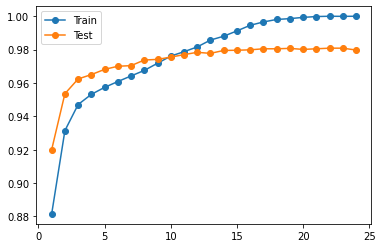

In [ ]:
# evaluate decision tree performance on train and test sets with different tree depths
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
# create dataset
# split into train test sets
X, y, T, gt = get_data_labels(pd.DataFrame(df_train_features),pd.DataFrame(b)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 25)]
# evaluate a decision tree for each depth
for i in values:
	# configure the model
	#model = DecisionTreeClassifier(max_depth=i)
	model = RandomForestClassifier(max_depth=i)

  
	# fit model on the training dataset
	model.fit(X_train, y_train)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train)
	train_acc = accuracy_score(y_train, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test)
	test_acc = accuracy_score(y_test, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.model_selection import train_test_split

X, y, T, gt = get_data_labels(df_train_features,b)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

trained_models = train_ml_models(X_train,y_train)

scores,true_preds,f1,recall, precisions = predict_ml_models(trained_models, X_test, y_test)

df_score = pd.DataFrame([scores]).T.rename(columns = {0:"accuracy"}).T
df_true_preds = pd.DataFrame([true_preds]).T.rename(columns = {0:"true pred rate"}).T
df_f1 = pd.DataFrame([f1]).T.rename(columns = {0:"f1 score"}).T
df_recall = pd.DataFrame([recall]).T.rename(columns = {0:"recall"}).T
df_precisions = pd.DataFrame([precisions]).T.rename(columns = {0:"precisions"}).T


pd.concat([df_score,df_true_preds,df_f1,df_recall,df_precisions])

In [ ]:
plot_model_information(trained_models, X_train, X_test, y_train, y_test, tree_plot=0, learning_curves=0, feature_importance=1, confusion_matrix=0)

## Hyperparamter tuning


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

a = df_train_features.copy()
a = pd.DataFrame(a)

groups = a.leak_type.values
y = a.leak_present.values
X = a#pd.DataFrame(a.drop(["leak_present"],axis=1))


cv = StratifiedGroupKFold(n_splits=2)

for train_idxs, test_idxs in cv.split(X,y, groups):
  print("TRAIN:" + str(np.unique(groups[train_idxs])) + ", " + str(len(groups[train_idxs])))
  print("TEST:" + str(np.unique(groups[test_idxs])) + ", " + str(len(groups[test_idxs])))

  rf = RandomForestClassifier(random_state=0)
  X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])
  X_train, X_test = preprocesses(X_train, X_test)
  
  rf.fit(X_train,y_train)
  score = rf.score(X_test , y_test)
  preds = rf.predict(X_test)
  print("f1: ", f1_score(preds, y_test))
  print("acc: ", score)
  print("")


In [ ]:
df_train_features["rp_0-12khz"] = df_train_features["rp_bin: 0"] + df_train_features["rp_bin: 1"]

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
best = []
for leak in df_train_features.leak_type.unique():
  X = df_train_features.loc[(df_train_features["leak_type"]==leak)]
  y = X.leak_present.values
  env_groups = X.mic.values

  cv = StratifiedGroupKFold(n_splits=3)

  for train_idxs, test_idxs in cv.split(X,y,env_groups):
    print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
    print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))

    ada = AdaBoostClassifier(random_state=0, n_estimators=350)
    rf = RandomForestClassifier(random_state=0)#, n_estimators=350)
    d = RandomForestClassifier(random_state=0)#, n_estimators=350)
    X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])
    #X_train, X_test = preprocesses(X_train, X_test)
    rf.fit(X_train,y_train)
    score = rf.score(X_test , y_test)
    preds = rf.predict(X_test)
    print(leak)
    print("f1: ", f1_score(preds, y_test))
    print("acc: ", score)
    model = {
        "rf" : rf
    }

    fi = plot_feature_importance2(model, X_train)
    print(X_train.columns[fi])
    best.append(X_train.columns[fi])

In [ ]:
for b in best: 
  print(np.flip(np.array(b[-5:])))

['rp_bin: 5' 'mfcc_bin: 5' 'mfcc_bin: 17' 'spec_bandwidth' 'zcr']
['rp_bin: 5' 'zcr' 'spec_flatness' 'mfcc_bin: 5' 'spec_bandwidth']
['rp_bin: 5' 'mfcc_bin: 5' 'zcr' 'mfcc_bin: 17' 'mfcc_bin: 7']


In [ ]:
def plot_feature_importance2(trained_models,train_data):
      features = train_data.columns
      for model in trained_models:
        try: 
          tree_feature_importances = trained_models[model].feature_importances_
          indices = np.argsort(tree_feature_importances)
          plt.figure(figsize=(15,10)) 
          plt.title(model + ' Feature Importances')
          plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
          plt.yticks(range(len(indices)), [features[i] for i in indices])
          plt.xlabel('Relative Importance')
        except:
          plt.close()
        plt.show()
        return indices


In [ ]:
X_train

,Unnamed: 0,spec_centroid,spec_bandwidth,spec_flatness,zcr,rmse,cont_bin: 0,cont_bin: 1,cont_bin: 2,cont_bin: 3,...,mfcc_bin: 17,mfcc_bin: 18,mfcc_bin: 19,rp_bin: 0,rp_bin: 1,rp_bin: 2,rp_bin: 3,rp_bin: 4,rp_bin: 5,rp_0-12khz
0,0,2184.208952,2456.884478,0.000132,0.054594,0.104045,28.610927,21.813530,27.350588,28.880250,...,6.221582,8.659132,5.202414,-0.010899,-4.578532,-7.553202,-10.116737,-12.323462,-14.297178,-4.589431
1,1,2813.248134,3399.272848,0.000981,0.055042,0.095649,31.070228,19.762933,23.796210,23.202295,...,6.131355,-6.087401,2.236220,-0.016584,-4.271874,-6.206551,-7.682237,-11.234858,-13.347136,-4.288459
2,2,2508.947054,2576.262818,0.000307,0.063479,0.084184,26.355137,23.638241,27.066303,24.291145,...,-5.825164,-5.114083,-5.449060,-0.021512,-3.906118,-6.799640,-10.056049,-11.993514,-14.550252,-3.927630
3,3,2449.903073,2544.197609,0.000148,0.070594,0.091334,27.945134,25.190866,26.418477,24.922329,...,-2.949644,2.631835,0.947582,-0.016035,-4.188232,-7.253357,-10.622684,-13.076220,-15.135993,-4.204267
4,4,2366.472151,2523.624477,0.000172,0.063146,0.094654,28.730049,23.481008,27.384736,25.200030,...,0.937316,4.715060,5.386179,-0.011478,-4.524319,-7.501890,-11.036529,-13.174254,-15.056807,-4.535797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39045,39045,2602.586557,3092.233234,0.000435,0.053260,0.092854,27.004563,23.575291,23.974175,28.734934,...,1.537053,3.252212,13.475432,-0.024264,-3.850144,-6.261217,-7.177092,-10.818846,-12.796341,-3.874408
39046,39046,2615.942444,3196.492140,0.000832,0.059135,0.089058,29.803072,19.355773,22.431855,23.707730,...,-1.924719,-11.036898,3.138512,-0.023656,-3.908044,-6.038125,-7.031668,-10.559565,-12.656057,-3.931700
39047,39047,2386.456919,2425.927149,0.000179,0.065344,0.090929,27.092433,23.307913,25.144435,31.631457,...,-6.236586,-3.771918,1.372371,-0.015990,-4.182414,-7.467715,-10.529488,-12.883428,-15.085775,-4.198403
39048,39048,2334.806164,2473.018775,0.000208,0.061083,0.079214,26.512014,24.591979,25.059360,27.072145,...,-2.659013,2.016132,3.212926,-0.018306,-4.049363,-7.300235,-10.488553,-12.930036,-14.909832,-4.067669


In [ ]:
df_train_features["rp_0-12khz"] = df_train_features["rp_bin: 0"] + df_train_features["rp_bin: 1"]  + df_train_features["rp_bin: 2"]
df_train_features["rp_12-20khz"] = df_train_features["rp_bin: 3"] + df_train_features["rp_bin: 4"]
df_train_features["rp_20-24khz"] = df_train_features["rp_bin: 5"]

In [ ]:
df_train_features = df_train_features.drop(columns={'rp_bin: 0', 'rp_bin: 1', 'rp_bin: 2', 'rp_bin: 3', 'rp_bin: 4', 'rp_bin: 5'})

TRAIN:[2 3], 26464
TEST:[1], 13504


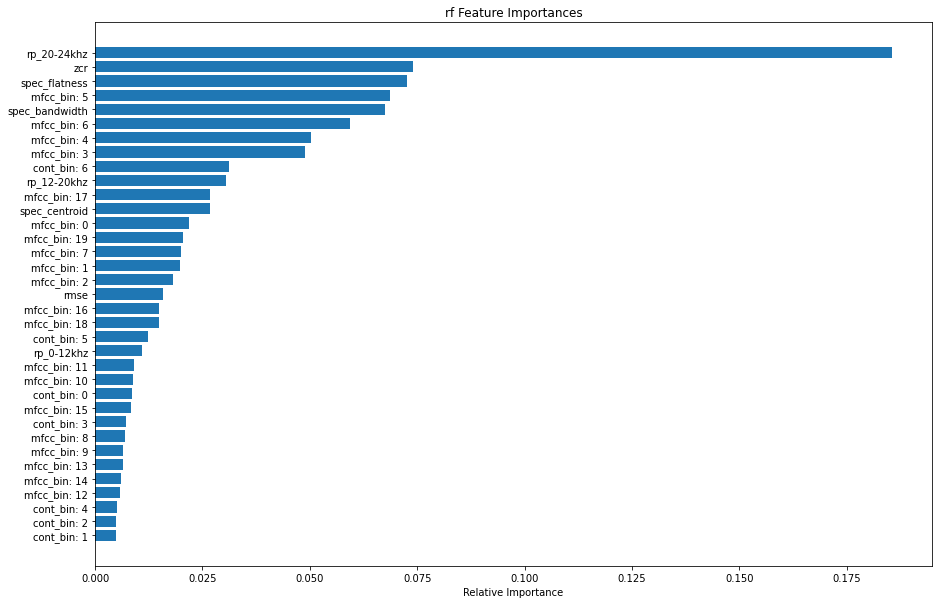

Index(['cont_bin: 1', 'cont_bin: 2', 'cont_bin: 4', 'mfcc_bin: 12',
       'mfcc_bin: 14', 'mfcc_bin: 13', 'mfcc_bin: 9', 'mfcc_bin: 8',
       'cont_bin: 3', 'mfcc_bin: 15', 'cont_bin: 0', 'mfcc_bin: 10',
       'mfcc_bin: 11', 'rp_0-12khz', 'cont_bin: 5', 'mfcc_bin: 18',
       'mfcc_bin: 16', 'rmse', 'mfcc_bin: 2', 'mfcc_bin: 1', 'mfcc_bin: 7',
       'mfcc_bin: 19', 'mfcc_bin: 0', 'spec_centroid', 'mfcc_bin: 17',
       'rp_12-20khz', 'cont_bin: 6', 'mfcc_bin: 3', 'mfcc_bin: 4',
       'mfcc_bin: 6', 'spec_bandwidth', 'mfcc_bin: 5', 'spec_flatness', 'zcr',
       'rp_20-24khz'],
      dtype='object')
TRAIN:[1 3], 26294
TEST:[2], 13674


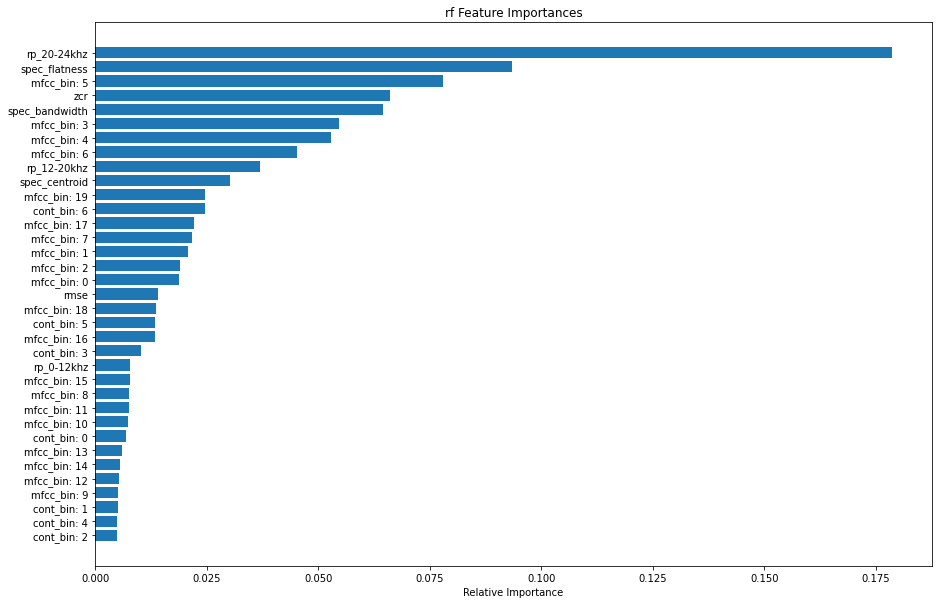

Index(['cont_bin: 2', 'cont_bin: 4', 'cont_bin: 1', 'mfcc_bin: 9',
       'mfcc_bin: 12', 'mfcc_bin: 14', 'mfcc_bin: 13', 'cont_bin: 0',
       'mfcc_bin: 10', 'mfcc_bin: 11', 'mfcc_bin: 8', 'mfcc_bin: 15',
       'rp_0-12khz', 'cont_bin: 3', 'mfcc_bin: 16', 'cont_bin: 5',
       'mfcc_bin: 18', 'rmse', 'mfcc_bin: 0', 'mfcc_bin: 2', 'mfcc_bin: 1',
       'mfcc_bin: 7', 'mfcc_bin: 17', 'cont_bin: 6', 'mfcc_bin: 19',
       'spec_centroid', 'rp_12-20khz', 'mfcc_bin: 6', 'mfcc_bin: 4',
       'mfcc_bin: 3', 'spec_bandwidth', 'zcr', 'mfcc_bin: 5', 'spec_flatness',
       'rp_20-24khz'],
      dtype='object')
TRAIN:[1 2], 27178
TEST:[3], 12790


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


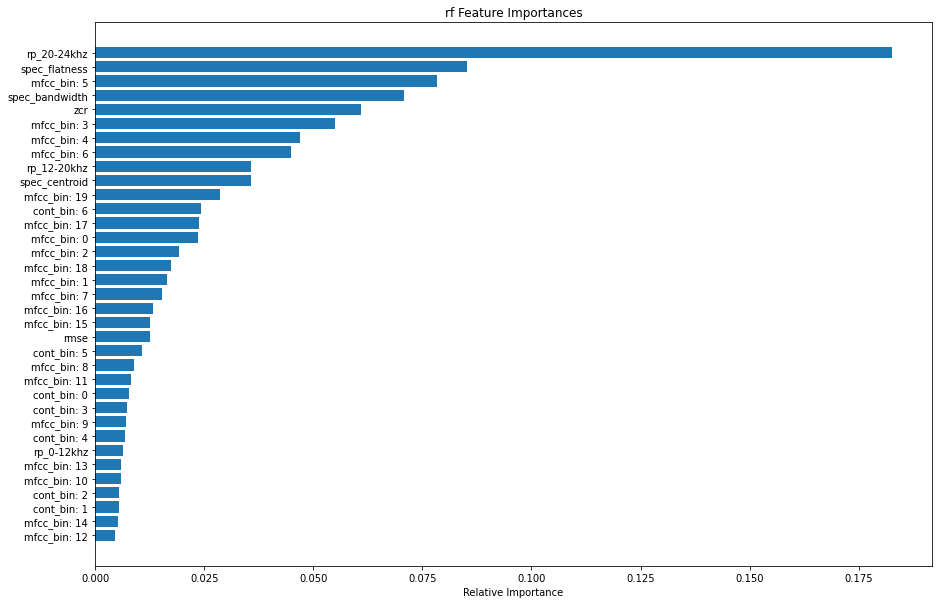

Index(['mfcc_bin: 12', 'mfcc_bin: 14', 'cont_bin: 1', 'cont_bin: 2',
       'mfcc_bin: 10', 'mfcc_bin: 13', 'rp_0-12khz', 'cont_bin: 4',
       'mfcc_bin: 9', 'cont_bin: 3', 'cont_bin: 0', 'mfcc_bin: 11',
       'mfcc_bin: 8', 'cont_bin: 5', 'rmse', 'mfcc_bin: 15', 'mfcc_bin: 16',
       'mfcc_bin: 7', 'mfcc_bin: 1', 'mfcc_bin: 18', 'mfcc_bin: 2',
       'mfcc_bin: 0', 'mfcc_bin: 17', 'cont_bin: 6', 'mfcc_bin: 19',
       'spec_centroid', 'rp_12-20khz', 'mfcc_bin: 6', 'mfcc_bin: 4',
       'mfcc_bin: 3', 'zcr', 'spec_bandwidth', 'mfcc_bin: 5', 'spec_flatness',
       'rp_20-24khz'],
      dtype='object')


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score
best = []
#for leak in df_train_features.leak_type.unique():
X = df_train_features #.loc[(df_train_features["leak_type"]==leak)]
y = X.leak_present.values
env_groups = X.recording.values


cv = StratifiedGroupKFold(n_splits=3)

results = {}

for train_idxs, test_idxs in cv.split(X,y,env_groups):
  print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
  print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))

  ada = AdaBoostClassifier(random_state=0, n_estimators=350)
  rf = RandomForestClassifier(random_state=0)#, n_estimators=350)
  d = RandomForestClassifier(random_state=0)#, n_estimators=350)

  X_test_info = X.iloc[test_idxs]
  
  X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])

  #X_train = X_train[['mfcc_bin: 5','spec_flatness', 'spec_bandwidth', 'zcr', 'rp_bin: 5']]
  #X_test = X_test[['mfcc_bin: 5','spec_flatness', 'spec_bandwidth', 'zcr', 'rp_bin: 5']]

  rf.fit(X_train,y_train)
  score = rf.score(X_test , y_test)
  preds = rf.predict(X_test)

  pred_col = pd.DataFrame(preds)
  pred_col.columns = ["preds"]
  pred_col.reset_index(drop=True, inplace=True)
  X_test_info.reset_index(drop=True, inplace=True)
  X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
  aaa = X_test_info_preds
  for leak in aaa.leak_type.unique():
    for env in aaa.environment.unique():
      #print(leak, env)
      preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
      y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
      #f1 = f1_score(preds, y_test)
      acc = accuracy_score(preds, y_test)
      #print(leak, env)
      #print(f1)
      key = str(leak + "-" + env)
      if key in results:
        results[key].append(acc)
      else:
        results[key] = [acc]
  
  model = {
      "rf" : rf
  }

  fi = plot_feature_importance2(model, X_train)
  print(X_train.columns[fi])
  #best.append(X_train.columns[fi])

  #print("f1: ", f1_score(preds, y_test))
  #print("acc: ", score)


#results



In [ ]:
results

In [ ]:
for key, vals in results.items():
    if 0 in vals:
      print(vals)
      vals.remove(0)
      print("removed 0 from ", key)

    print("Average for {} is {}".format(key,np.mean(vals)))

Average for ventleak-hydr is 0.9514894377821235
Average for ventleak-lab is 0.9992706053975201
Average for ventleak-work is 0.9873084586068511
Average for ventleak-hydr_low is 0.98102591133529
Average for ventleak-work_low is nan
Average for ventlow-hydr is 0.9415132898829492
Average for ventlow-lab is 0.9767371861025111
Average for ventlow-work is 0.9602090513596084
Average for ventlow-hydr_low is 0.9428981106612686
Average for ventlow-work_low is 0.9436361924382948
Average for tubeleak-hydr is 0.9143312038969539
Average for tubeleak-lab is 0.9755667721214553
Average for tubeleak-work is 0.9537359973754534
Average for tubeleak-hydr_low is 0.956671890278667
Average for tubeleak-work_low is 0.960476048748253


In [ ]:
X_test_info_preds.loc[X_test_info_preds.leak_type =="ventleak"]

In [ ]:
pred_col = pd.DataFrame(preds)
pred_col.columns = ["preds"]
pred_col.reset_index(drop=True, inplace=True)
X_test_info.reset_index(drop=True, inplace=True)
X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
aaa = X_test_info_preds
for leak in aaa.leak_type.unique():
  for env in aaa.environment.unique():
    preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
    y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
    f1 = f1_score(preds, y_test)
    print(leak, env)
    print(f1)

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
best = []
#for leak in df_train_features.leak_type.unique():
X = df_train_features #.loc[(df_train_features["leak_type"]==leak)]
y = X.leak_present.values
env_groups = X.recording.values


cv = StratifiedGroupKFold(n_splits=3)

for train_idxs, test_idxs in cv.split(X,y,env_groups):
  print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
  print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))

  ada = AdaBoostClassifier(random_state=0, n_estimators=350)
  rf = RandomForestClassifier(random_state=0)#, n_estimators=350)
  d = RandomForestClassifier(random_state=0)#, n_estimators=350)

  
  X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])
  #X_train, X_test = preprocesses(X_train, X_test)
  rf.fit(X_train,y_train)
  score = rf.score(X_test , y_test)
  preds = rf.predict(X_test)

  print("f1: ", f1_score(preds, y_test))
  print("acc: ", score)
  """  model = {
      "rf" : rf
  }
  fi = plot_feature_importance2(model, X_train)
  print(X_train.columns[fi])
  best.append(X_train.columns[fi])"""